In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
import os

import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

!pip install pyalgotrade
from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma
from pyalgotrade.stratanalyzer import returns
from pyalgotrade.bar import BasicBar, Frequency
from pyalgotrade.barfeed import membf
import datetime
from pyalgotrade.stratanalyzer import returns, trades, sharpe
import logging

import sklearn
from sklearn.metrics import roc_auc_score

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

LGBM import

In [2]:
!pip install lightgbm
import lightgbm as lgbm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


data preprocessing

In [4]:
# file path
folder_path = '/content/drive/MyDrive/kospi_sim/'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# save each csv file to df list
df = []
for i , file_name in enumerate(csv_files):
  file_path = os.path.join(folder_path, file_name)
  p=pd.read_csv(file_path)
  df.append(p)

In [5]:
# rename columns , drop 'date' , 'Adj Close'
stock_len = int(len(df))
for i in range(stock_len):
  if 'Adj Close' in df[i].columns:
    df[i] = df[i].drop(['Adj Close'] , axis = 1)
  if 'Date' in df[i].columns:
    df[i] = df[i].drop(['Date'] , axis = 1)
for i in range(len(df)):
  df[i] = df[i].rename(columns={'close': 'Close', 'open': 'Open' , 'low': 'Low', 'high' : 'High' , 'volume' : 'Volume'})

In [6]:
# if 0 exist, delete
for i in range(len(df)):
  s = df[i]
  s = s.drop(s[s['Close'] == 0].index , axis=0)
  s = s.drop(s[s['Open'] == 0].index , axis=0)
  s = s.drop(s[s['Volume'] == 0].index , axis=0)
  s = s.dropna(axis=0)
  df[i] = s

In [ ]:
# generating target col
stock_len = int(len(df))
for i in range(stock_len):
  s = df[i]
  mid = pd.DataFrame()

  for j in range(1,11):
    mid[f'close_{j}'] = s['Close'].shift(-j)
  for j in range(1,11):
    mid[f'open_{j}'] = s['Open'].shift(-j)

  mid['target'] = ((s['Close'] - mid['close_1'])/mid['close_1']) + 1
  mid = mid.dropna(axis=0)
  mid[mid > 300000] = 300000
  mid[mid < -300000] = -300000
  df[i] = mid

In [8]:
s = df[0]
for i in range(1,len(df)):
  s = pd.concat([s,df[i]])
df = s

In [9]:
#결측값 제거
df = df.dropna(axis = 0)

# data, target 분리
df_data = df.iloc[:,:-1]
df_target = df.iloc[:,-1]

# target 클래스화
df_where = df_target.where(df_target >= 1.04, -1)
df_target = df_where.where(df_where < 1.04, 1)

# scaling
df_data['row_max'] = df_data.max(axis=1)
df_data['row_min'] = df_data.min(axis = 1)

df_data = df_data.apply(lambda row: (row - row['row_min']) / (row['row_max'] - row['row_min']), axis=1)
df_data.drop(['row_max','row_min'] , axis= 1 , inplace=True)

second data preprocessing

In [10]:
df_data['close_2_/_close_3'] = df_data['close_2'] / df_data['close_3']
df_data['close_1_clse_2_close_3'] = df_data['close_1'] * df_data['close_2'] * df_data['close_3']

dataframe -> tensor

In [11]:
def df_to_tensor(df):
  return torch.tensor(df.values)

Heatmap

In [12]:
def heatmap(df , df_final):
  # 데이터프레임의 상관계수 계산

  df['pred'] = df_final # df_final.shape : (n,1)
  corr = df.corr()

  # 상관계수 히트맵 그리기
  plt.figure(figsize=(8, 6))
  sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
  plt.title('Correlation Heatmap')
  plt.show()

further processing

In [13]:
def data_preprocessing(df):
  return df

In [14]:
def feature_importance(lgb_model):
  lgbm.plot_importance(lgb_model, max_num_features=10, importance_type='split')  # 'split' or 'gain' 옵션 가능
  plt.title("Feature Importance using LightGBM")
  plt.show()

kospi , kosdaq_list

In [15]:
kosdaq = ['900110', '900270', '900260', '900290', '900300', '900310', '900340', '000250', '000440', '001000', '001540', '001810', '001840', '002230', '002290', '002680', '002800', '003100', '003310', '003380', '003800', '004590', '004650', '004780', '005160', '005290', '005670', '005710', '005860', '005990', '006050', '006140', '006620', '006730', '006910', '006920', '007330', '007370', '007390', '007530', '007680', '007720', '007770', '007820', '008290', '008370', '008470', '008830', '009300', '009520', '009620', '009730', '009780', '010170', '010240', '010280', '010470', '011040', '011080', '011320', '011370', '011560', '012340', '012620', '012700', '012790', '012860', '013030', '013120', '013310', '013720', '013810', '013990', '014100', '014190', '014200', '014470', '014570', '014620', '014940', '014970', '015710', '015750', '016100', '016250', '016600', '016670', '016790', '016920', '017000', '017250', '017480', '017510', '017650', '017890', '018000', '018120', '018290', '018310', '018620', '018680', '018700', '019010', '019210', '019540', '019550', '019570', '019590', '019660', '019770', '019990', '020180', '020400', '020710', '021040', '021045', '021080', '021320', '021650', '021880', '022220', '023160', '023410', '023440', '023460', '023600', '023760', '023770', '023790', '023900', '023910', '024060', '024120', '024740', '024800', '024810', '024830', '024840', '024850', '024880', '024910', '024940', '024950', '025320', '025440', '025550', '025770', '025870', '025880', '025900', '025950', '025980', '026040', '026150', '026910', '027040', '027050', '027360', '027580', '027710', '027830', '028080', '028300', '029480', '029960', '030350', '030520', '030530', '030960', '031310', '031330', '031510', '031860', '031980', '032080', '032190', '032280', '032300', '032500', '032540', '032580', '032620', '032680', '032685', '032750', '032790', '032800', '032820', '032850', '032860', '032940', '032960', '032980', '033050', '033100', '033130', '033160', '033170', '033200', '033230', '033290', '033310', '033320', '033340', '033500', '033540', '033560', '033640', '033790', '033830', '034810', '03481K', '034940', '034950', '035080', '035200', '035290', '035460', '035600', '035610', '035620', '035760', '035810', '035890', '035900', '036000', '036010', '036030', '036090', '036120', '036170', '036180', '036190', '036200', '036220', '036480', '036540', '036560', '036620', '036630', '036640', '036670', '036690', '036710', '036800', '036810', '036830', '036890', '036930', '037030', '037070', '037230', '037330', '037350', '037370', '037400', '037440', '037460', '037760', '037950', '038010', '038060', '038070', '038110', '038290', '038340', '038390', '038460', '038500', '038530', '038540', '038620', '038680', '038870', '038880', '038950', '039010', '039020', '039030', '039200', '039240', '039290', '039310', '039340', '039420', '039440', '039560', '039610', '039740', '039830', '039840', '039860', '039980', '040160', '040300', '040350', '040420', '040610', '040910', '041020', '041190', '041440', '041460', '041510', '041520', '041590', '041830', '041910', '041920', '041930', '041960', '042000', '042040', '042110', '042370', '042420', '042500', '042510', '042520', '042600', '042940', '043090', '043100', '043150', '043200', '043220', '043260', '043340', '043360', '043370', '043590', '043610', '043650', '043710', '043910', '044060', '044180', '044340', '044480', '044490', '044780', '044960', '045060', '045100', '045300', '045340', '045390', '045510', '045520', '045660', '045970', '046070', '046120', '046210', '046310', '046390', '046440', '046890', '046940', '046970', '047080', '047310', '047560', '047770', '047820', '047920', '048410', '048430', '048470', '048530', '048550', '048770', '048830', '048870', '048910', '049070', '049080', '049120', '049180', '049430', '049470', '049480', '049520', '049550', '049630', '049720', '049830', '049950', '049960', '050090', '050110', '050120', '050760', '050860', '050890', '050960', '051160', '051360', '051370', '051380']
kospi = ['000020', '000040', '000050', '000070', '000075', '000080', '000087', '000100', '000105', '000120', '000140', '000145', '000150', '000155', '000157', '000180', '000210', '000215', '000220', '000225', '000227', '000230', '000240', '000270', '000300', '000320', '000325', '000370', '000390', '000400', '000430', '000480', '000490', '000500', '000520', '000540', '000545', '000590', '000640', '000650', '000660', '000670', '000680', '000700', '000720', '000725', '000760', '000810', '000815', '000850', '000860', '000880', '000885', '00088K', '000890', '000910', '000950', '000970', '000990', '001020', '001040', '001045', '00104K', '001060', '001065', '001067', '001070', '001080', '001120', '001130', '001140', '001200', '001210', '001230', '001250', '001260', '001270', '001275', '001290', '001340', '001360', '001380', '001390', '001420', '001430', '001440', '001450', '001460', '001465', '001470', '001500', '001510', '001515', '001520', '001525', '001527', '001530', '001550', '001560', '001570', '001620', '001630', '001680', '001685', '001720', '001740', '001750', '001755', '001770', '001780', '001790', '001795', '001800', '001820', '001940', '002020', '002025', '002030', '002070', '002100', '002140', '002150', '002170', '002200', '002210', '002220', '002240', '002310', '002320', '002350', '002355', '002360', '002380', '002390', '002410', '002420', '002450', '002460', '002600', '002620', '002630', '002690', '002700', '002710', '002720', '002760', '002780', '002785', '002787', '002790', '002795', '00279K', '002810', '002820', '002840', '002870', '002880', '002900', '002920', '002960', '002990', '002995', '003000', '003010', '003030', '003060', '003070', '003075', '003080', '003090', '003120', '003160', '003200', '003220', '003230', '003240', '003280', '003300', '003350', '003460', '003465', '003470', '003475', '003480', '003490', '003495', '003520', '003530', '003535', '003540', '003545', '003547', '003550', '003555', '003560', '003570', '003580', '003610', '003620', '003650', '003670', '003680', '003690', '003720', '003780', '003830', '003850', '003920', '003925', '003960', '004000', '004020', '004060', '004080', '004090', '004100', '004105', '004140', '004150', '004170', '004250', '004255', '004270', '004310', '004360', '004365', '004370', '004380', '004410', '004415', '004430', '004440', '004450', '004490', '004540', '004545', '004560', '004690', '004700', '004710', '004720', '004770', '004800', '004830', '004835', '004840', '004870', '004890', '004910', '004920', '004960', '004970', '004980', '004985', '004990', '00499K', '005010', '005030', '005070', '005090', '005110', '005180', '005250', '005257', '005300', '005305', '005320', '005360', '005380', '005385', '005387', '005389', '005390', '005420', '005430', '005440', '005490', '005500', '005610', '005680', '005690', '005720', '005725', '005740', '005745', '005750', '005800', '005810', '005820', '005830', '005850', '005870', '005880', '005930', '005935', '005940', '005945', '005950', '005960', '005965', '006040', '006060', '006090', '006110', '006120', '006125', '006200', '006220', '006260', '006280', '006340', '006345', '006360', '006370', '006380', '006390', '006400', '006405', '006490', '006570', '006650', '006660', '006740', '006800', '006805', '00680K', '006840', '006880', '006890', '006980', '007070', '007110', '007120', '007160', '007210', '007280', '007310', '007340', '007460', '007540', '007570', '007575', '007590', '007610', '007660', '007690', '007700', '007810', '007815', '00781K', '007860', '007980', '008040', '008060', '00806K', '008110', '008250', '008260', '008350', '008355', '008420', '008490', '008500', '008600', '008700', '008730', '008770', '008775', '008870', '008930', '008970', '009070', '009140', '009150', '009155', '009160', '009180', '009190', '009200', '009240', '009270', '009290', '009310', '009320', '009410', '009415', '009420', '009440', '009450', '009460', '009470', '009540', '009580', '009680', '009770', '009810', '009830', '009835', '009900', '009970']

params

In [16]:
bayesian_params = {
    'num_leaves' : (100,200) , 'min_child_samples': (100,200),
    'min_child_weight':(1,50),'sub_sample':(0.5,1.0),'colsample_bytree':(0.5,1.0),
    'max_bin':(10,500), 'reg_lambda':(0.001,10),'reg_alpha':(0.001,1)
}

LGBM

early stop , verbose

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.2, random_state=42)

def lgb(num_leaves,min_child_samples,min_child_weight,sub_sample,colsample_bytree,
        max_bin,reg_lambda,reg_alpha):

  params = {
    "n_estimators":1000,'learning_rate':0.01,'max_depth':-1,
    'num_leaves':int(round(num_leaves)),'min_child_samples':int(round(min_child_samples)),
    'min_child_weight':int(round(min_child_weight)),'sub_sample':max(min(sub_sample, 1), 0),
    'colsample_bytree':max(min(colsample_bytree, 1), 0),'max_bin': max(int(round(max_bin)),10),
    'reg_lambda':max(reg_lambda,0),'reg_alpha':max(reg_alpha, 0),
    'random_state' : 42,
}

  # 하이퍼파라미터 변경
  lgb_model = lgbm.LGBMClassifier(**params)
  lgb_model.fit(X_train, y_train , eval_set = [(X_test, y_test)])

  valid_proba = lgb_model.predict_proba(X_test)[:,1]
  roc_auc = roc_auc_score(y_test , valid_proba)

  return roc_auc

bayesian LGBM experiment

In [18]:
lgbm_bayesian = BayesianOptimization(f=lgb, pbounds=bayesian_params)
lgbm_bayesian.maximize(init_points=5, n_iter=5)

|   iter    |  target   | colsam... |  max_bin  | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | sub_sa... |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] Number of positive: 7886, number of negative: 177935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9481
[LightGBM] [Info] Number of data points in the train set: 185821, number of used features: 22
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042439 -> initscore=-3.116329
[LightGBM] [Info] Start training from score -3.116329
[LightGBM] [Warning] Unknown parameter: sub_sample
| 1         | 0.6278    | 0.6295    | 430.7     | 104.7  

In [19]:
print(lgbm_bayesian.max)

{'target': 0.6316916923270628, 'params': {'colsample_bytree': 0.7001633218385279, 'max_bin': 495.9952368064078, 'min_child_samples': 178.35805212269003, 'min_child_weight': 17.00237560096438, 'num_leaves': 140.85148486131413, 'reg_alpha': 0.1929933691618598, 'reg_lambda': 2.3491564484573706, 'sub_sample': 0.9271406452092448}}


target이 올랐냐 내렸냐 기준일때 roc_auc 값 : 0.5526661311522713

tuned lgbm fit

In [20]:
lgb_model = lgbm.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=14,
    num_leaves=57,
    reg_alpha=0.5427965,
    reg_lambda=5.489,
    min_child_samples=109,
    min_child_weight=15,
    colsample_bytree=0.571133,
    max_bin=333
)

lgb_model.fit(X_train,y_train,eval_set=[(X_test,y_test)])

[LightGBM] [Info] Number of positive: 7886, number of negative: 177935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7326
[LightGBM] [Info] Number of data points in the train set: 185821, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042439 -> initscore=-3.116329
[LightGBM] [Info] Start training from score -3.116329


LGBMClassifier(colsample_bytree=0.571133, learning_rate=0.02, max_bin=333,
               max_depth=14, min_child_samples=109, min_child_weight=15,
               n_estimators=500, num_leaves=57, reg_alpha=0.5427965,
               reg_lambda=5.489)

feature importance visualization

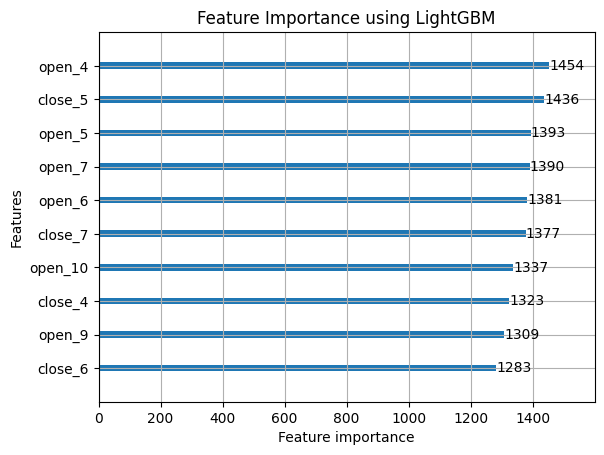

In [21]:
feature_importance(lgb_model)

heat map visualization

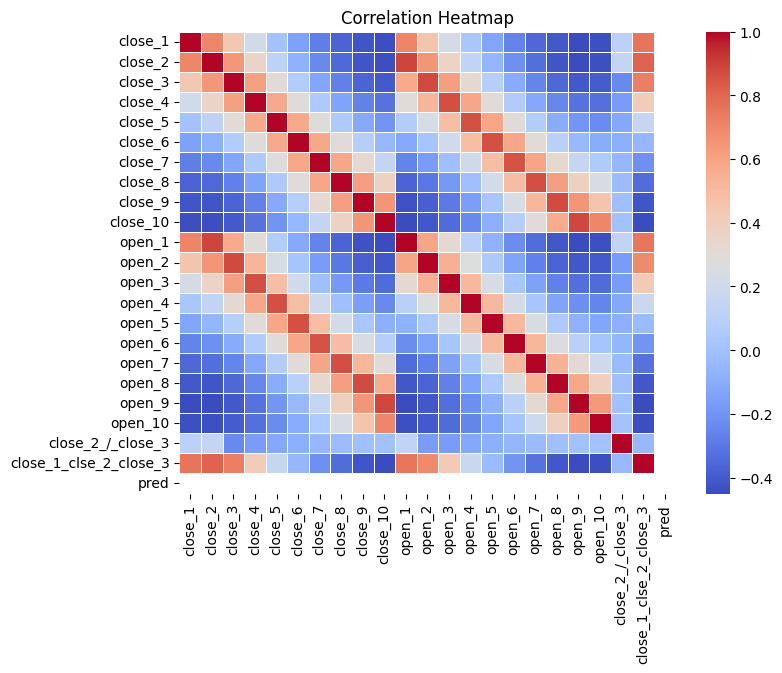

In [22]:
pred = lgb_model.predict(X_test)
heatmap(X_test , pred)

inference

In [23]:
answer_prob = sum((pred - y_test)**2)/len(pred)
answer_prob

0.17151713449285344

Back testing

In [24]:
class DeepLearningStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, model):
        super(DeepLearningStrategy, self).__init__(feed)
        self.__instrument = instrument
        self.__position = None
        self.__model = model
        self.__prices = []  # 종가 데이터를 저장할 리스트
        self.__opens=[]
        self.__volumes = []  # 거래량 데이터를 저장할 리스트
        self.__buy_date = None  # 매수 날짜 저장 변수
        self.__target_price = None  # 목표가 저장 변수
        self.feed=feed

    def onBars(self, bars):
        bar = bars[self.__instrument]
        self.__prices.append(bar.getClose())   # 종가 데이터를 저장
        self.__opens.append(bar.getOpen())
        current_date = bar.getDateTime()

        # 데이터가 있는지 확인
        date_times = self.feed[self.__instrument].getDateTimes()
        if len(date_times) > 0:
            date_len = len(date_times)-1
            self.__last_date = date_times[date_len]  # 마지막 날짜 저장
        else:
            self.__last_date = None  # 데이터가 없을 경우 None으로 설정

        # 최소 50일치 데이터가 있어야 예측 가능
        if len(self.__prices) < 13:
            return

        # 마지막 20일의 거래량 데이터 가져오기
        price = []
        for i in range(-1, -11, -1):  # 마지막 20일간의 데이터
            price_t = self.__prices[i]
            price.append(price_t)
        open = []
        for i in range(-1, -11, -1):  # 마지막 20일간의 데이터
            open_t = self.__opens[i]
            open.append(open_t)

        price=torch.Tensor(price).unsqueeze(1)
        price=price.reshape(1,-1)
        open=torch.Tensor(open).unsqueeze(1)
        open=open.reshape(1,-1)

        input_0 = (price[:,1] / price[:,2]).unsqueeze(1)
        input_1 = (price[:,0] * price[:,1] * price[:,2]).unsqueeze(1)

        x = torch.cat([price,open,input_0,input_1],axis=1)

        x = (x - x.min())/(x.max() - x.min())

        # 딥러닝 모델로 다음 날 가격 예측
        #self.__model.eval()
        prediction = self.__model.predict(x)
        #predicted_classes = int(100*prediction[0])
        #predicted_classes = torch.argmax(prediction, dim=1)

        # 간단한 매수/매도 로직
        if self.__position is None:
            if prediction >= 1:  # 예측된 가격이 현재 가격보다 크면 매수
                available_cash = self.getBroker().getCash()  # 현재 자산(현금)
                price_per_share = bar.getClose()  # 현재 주가
                current_date = bar.getDateTime()

                # 구매 가능한 최대 주식 수 계산 (수수료 및 추가 비용을 15%로 가정)
                max_shares = int(available_cash / (price_per_share * 1.01))

                if max_shares > 0:
                    self.__position = self.enterLong(self.__instrument, max_shares)
                    self.__buy_date = bar.getDateTime()  # 매수 날짜를 저장
                    self.info(f"매수 메시지: {bar.getDateTime()}에 {bar.getPrice()}에 매수함")
                    self.__target_price = bar.getClose() * 1.15  # 목표가를 설정 (4% 상승)
                    self.__current_price = bar.getClose()
        elif self.__position is not None and not self.__position.exitActive():
          high_price_today = bar.getHigh()  # 오늘의 최고가
          low_price_today = bar.getLow()
          current_date = bar.getDateTime()

          if (current_date - self.__buy_date).days > 30 and high_price_today >= self.__current_price * 1.5:
            self.info(f"5일 경과 후 강제 매도: {current_date}에 {bar.getPrice()}에 매도함")
            self.__position.exitMarket()
            self.__position = None  # 매도 후 포지션 초기화
          elif (current_date - self.__buy_date).days > 400:
            self.info(f"5일 경과 후 강제 매도: {current_date}에 {bar.getPrice()}에 매도함")
            self.__position.exitMarket()
            self.__position = None  # 매도 후 포지션 초기화

In [25]:
def backtesting(df):
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

  df.replace([np.inf], 300000, inplace=True)
  df.replace([-np.inf], -300000, inplace=True)

  filtered_df = df[
    (df['Low'] <= df['Open']) &   # Low가 Open보다 크면 안 됨
    (df['Low'] <= df['Close']) &  # Low가 Close보다 크면 안 됨
    (df['Low'] <= df['High']) &   # Low가 High보다 크면 안 됨
    (df['High'] >= df['Open']) &  # High는 Open보다 작으면 안 됨
    (df['High'] >= df['Close']) & # High는 Close보다 작으면 안 됨
    (df['Volume'] > 0)           # 거래량은 음수일 수 없음
  ]

  #  변환된 DataFrame을 다시 CSV 파일로 저장
  filtered_df.to_csv('AAPL_fixed.csv', index=False)

  # Yahoo 피드 준비
  feed = yahoofeed.Feed()
  feed.addBarsFromCSV("aapl", "AAPL_fixed.csv")

  # 전략 실행 (딥러닝 모델을 통합)
  start = DeepLearningStrategy(feed, "aapl", lgb_model)

  # 수익률 분석기 추가
  returnsAnalyzer = returns.Returns()
  start.attachAnalyzer(returnsAnalyzer)

  # 트레이드 분석기 추가 (거래 내역 및 수익 확인)
  tradesAnalyzer = trades.Trades()
  start.attachAnalyzer(tradesAnalyzer)

  # 백테스트 실행
  initial_cash = start.getBroker().getCash()
  logging.getLogger("broker.backtesting").setLevel(logging.CRITICAL)
  start.run()
  profit = ((tradesAnalyzer.getProfits().sum() + tradesAnalyzer.getLosses().sum())/ initial_cash) * 100

  return profit,tradesAnalyzer.getCount()

In [26]:
sum_profit =0
sum_trade_num = 0
cnt = 0
zero_num = 0

for stock in kosdaq:
  cnt += 1
  df = pd.read_csv('/content/drive/MyDrive/kosdaq_sim/' + stock + '.csv')
  df[df.columns[0]] = pd.to_datetime(df.iloc[:, 0].astype(str), format='%Y%m%d')
  df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
  df['Adj Close']=df['close']
  df['Low']=df['low']
  df['High']=df['high']
  df['Open']=df['open']
  df['Close']=df['close']
  df['Volume']=df['volume']
  df=df.drop(['low','high','open','close','volume'],axis=1)
  a1 , a2 = backtesting(df)
  if a2 == 0:
    zero_num += 1
  if a2 != 0:
    sum_profit += a1-(a2/2)
    sum_trade_num += a2
    print(stock, a1-(a2/2), a2)
print(sum_profit/(cnt-zero_num), sum_trade_num/(cnt-zero_num) , zero_num)

KeyboardInterrupt: 

online learning

In [ ]:
# 기존 모델 불러오기
model = torch.load("trained_model.pth")  # 훈련된 모델 로드

In [ ]:
model = ...

# new dataset


In [ ]:
# 새로운 데이터에 대해 모델 재학습
model.train()
for epoch in range(3):  # 간단히 3 epoch 동안만 학습
    for inputs, labels in new_loader:
        optimizer.zero_grad()  # 기존 Gradient 초기화
        outputs = model(inputs)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # Backpropagation 수행
        optimizer.step()  # 모델 파라미터 업데이트
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

In [ ]:
# 학습된 모델 저장
torch.save(model, "online_trained_model.pth")